In [0]:
""" Notebook was run using Colab GPU """

import pickle
import numpy as np
import torch
import math
import ipywidgets
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import torch.nn.functional as F
import torch.nn as nn
torch.set_flush_denormal(True)

True

In [0]:
""" 
Follows structure from the original paper. Creates masks for each kernel in the conv net. 
Mask A masks the kernel such that each pixel cannot depend on itself. This condition
is relaxed in the subsequent layers via mask B.
"""

def get_mask_pc(in_channels,out_channels,kernel_size,mask_type):

    mask = torch.ones(out_channels, in_channels, kernel_size, kernel_size).cuda()
    mask[:, :, math.ceil(len(mask[0][0]) / 2):len(mask[0][0])] = 0

    if mask_type == 'A':

        mask[:, :, len(mask[0][0]) // 2, len(mask[0][0][0]) // 2:len(mask[0][0][0])] = 0
    else:
        mask[:, :, len(mask[0][0]) // 2, math.ceil(len(mask[0][0][0]) / 2):len(mask[0][0][0])] = 0

    return mask

""" Masks each kernel in the layer """

class MaskedConv2D(nn.Conv2d):

    def __init__(self, in_channels, out_channels, kernel_size, mask, stride=1,
                 padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros'):

        super().__init__(in_channels, out_channels, kernel_size, stride, padding, dilation, groups,
                 bias, padding_mode)

        self.mask = mask

    def forward(self, input):
        return F.conv2d(input, torch.mul(self.mask, self.weight), self.bias, padding=self.padding)

In [0]:
""" Residual Block following the implementation described in the Pixel-CNN paper"""

class ResBlock(nn.Module):

    def __init__(self, in_channel, mask):
        super(ResBlock, self).__init__()

        self.conv1 = torch.nn.Conv2d(in_channel, in_channel // 2, 1)
        self.relu = torch.nn.ReLU(inplace=True)
        self.conv2 = MaskedConv2D(in_channel // 2, in_channel // 2, 3, mask=mask, padding=1)
        self.conv3 = torch.nn.Conv2d(in_channel // 2, in_channel, 1)

    def forward(self, input):
        out = self.conv1(input)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = out + input
        return out

In [0]:
""" Full Pixel-CNN with 12 residual blocks"""

class PixelCNN(torch.nn.Module):

    def __init__(self,block,first_mask,second_mask):
        super(PixelCNN, self).__init__()

        self.first_mask = first_mask
        self.second_mask = second_mask

        self.l1 = MaskedConv2D(3, 256, mask=first_mask, kernel_size=7,padding=3)
        self.relu = torch.nn.ReLU()
        self.res = self.res_layers(block)
        self.l2 = torch.nn.Conv2d(256, 32, 1)
        self.l3 = torch.nn.Conv2d(32, 12, 1)

    def res_layers(self, block):
        layers = []
        for i in range(12):
            layers.append(block(256, self.second_mask))

        return nn.Sequential(*layers)

    def forward(self, input):
      out = self.l1(input)
      out = self.relu(out)
      out = self.res(out)
      out = self.relu(out)
      out = self.l2(out)
      out = self.relu(out)
      out = self.l3(out)
      out = out.view(input.shape[0],3,4,28,28)
      out = out.permute(0, 1, 3, 4, 2)
        
      return out

In [0]:
torch.manual_seed(0)

with open('mnist-hw1.pkl', 'rb') as f:
    dataset = pickle.load(f)

training_set = torch.Tensor(dataset['train'][0:50000].astype('float32')).permute(0, 3, 1, 2)
validation_set = torch.Tensor(dataset['train'][50000:60000].astype('float32')).permute(0, 3, 1, 2)
test_set = torch.Tensor(dataset['test'].astype('float32')).permute(0, 3, 1, 2)

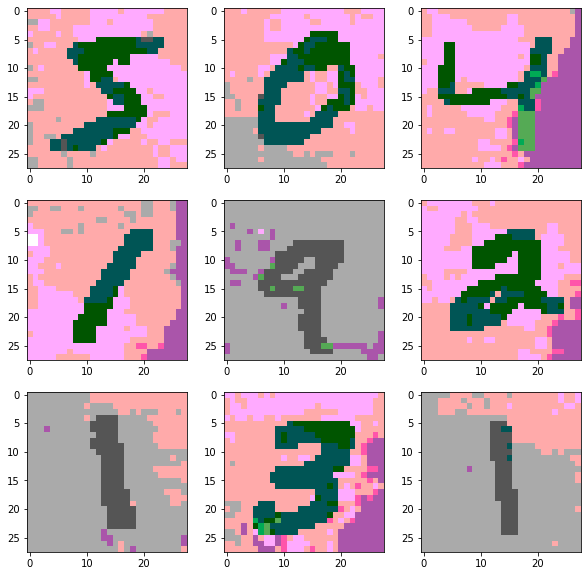

In [0]:
""" 
Samples from the provided colored MNIST dataset
Provided images have been quantized into two bits per color channel
"""

f, axarr = plt.subplots(3,3,figsize=(10,10))
k = 0
for i in range(3):
  for j in range(3):
    axarr[i,j].imshow(training_set[k].permute(1,2,0)/3)
    k+=1

In [0]:
batch_size = 128

training_data = torch.utils.data.DataLoader(training_set, batch_size=batch_size, shuffle=True)
validation_data = torch.utils.data.DataLoader(validation_set, batch_size=batch_size, shuffle=True)
test_data = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

In [0]:
""" 
Precomputing mask to speed up training. We only need two
separate mask for the model in practice as 1x1 convolutions past the first layer 
need no masking.
"""

mask1_pc = get_mask_pc(3, 256, 7, 'A')
mask2_pc = get_mask_pc(128, 128, 3, 'B')

pixel_cnn = PixelCNN(ResBlock,mask1_pc,mask2_pc)

use_cuda = True
if use_cuda and torch.cuda.is_available():
  pixel_cnn.cuda()

epochs = 35
optimizer = torch.optim.Adam(pixel_cnn.parameters(), lr=0.001)

training_loss = []
validation_loss = []

""" Training Loop"""

m=0
for i in range(epochs):
    j=0
    for batch in training_data:
      optimizer.zero_grad()
      batch = batch.cuda()
      logits = pixel_cnn.forward(batch)
      logits = logits.flatten(0,3)

      """ Converting to log base 2 """

      loss = F.cross_entropy(logits,batch.flatten().long()) * np.log2(np.e)

      if j == len(training_data)-1 or (i == 0 and j == 0):
        print("Epoch:",i, "  Batch:",j,"  Loss:",loss.item(),"bits/dim")

      training_loss.append(loss.item())
      j += 1
      m += 1
      loss.backward()
      torch.nn.utils.clip_grad_norm_(pixel_cnn.parameters(), 1)
      optimizer.step()

      if m % 50 == 0 or j == len(training_data)-1 or (i==0 and j==1):
        with torch.no_grad():
          total_val_loss = 0
          pixel_cnn.eval()
          for batch in validation_data:
            batch = batch.cuda()
            val_logits = pixel_cnn.forward(batch)
            val_logits = val_logits.flatten(0,3)

            val_loss = F.cross_entropy(val_logits,batch.flatten().long())* np.log2(np.e)
            total_val_loss += val_loss.item()
          for num in range(m):
            validation_loss.append(total_val_loss/len(validation_data))
          pixel_cnn.train()
          m = 0

Epoch: 0   Batch: 0   Loss: 1.9630123376846313 bits/dim
Epoch: 0   Batch: 390   Loss: 0.3054168224334717 bits/dim
Epoch: 1   Batch: 390   Loss: 0.2119177132844925 bits/dim
Epoch: 2   Batch: 390   Loss: 0.15296487510204315 bits/dim
Epoch: 3   Batch: 390   Loss: 0.14833229780197144 bits/dim
Epoch: 4   Batch: 390   Loss: 0.14317865669727325 bits/dim
Epoch: 5   Batch: 390   Loss: 0.13886070251464844 bits/dim
Epoch: 6   Batch: 390   Loss: 0.13501664996147156 bits/dim
Epoch: 7   Batch: 390   Loss: 0.13548004627227783 bits/dim
Epoch: 8   Batch: 390   Loss: 0.1296525001525879 bits/dim
Epoch: 9   Batch: 390   Loss: 0.1304219663143158 bits/dim
Epoch: 10   Batch: 390   Loss: 0.1344759464263916 bits/dim
Epoch: 11   Batch: 390   Loss: 0.12873581051826477 bits/dim
Epoch: 12   Batch: 390   Loss: 0.12604087591171265 bits/dim
Epoch: 13   Batch: 390   Loss: 0.1307927668094635 bits/dim
Epoch: 14   Batch: 390   Loss: 0.12868918478488922 bits/dim
Epoch: 15   Batch: 390   Loss: 0.1280529648065567 bits/dim
E

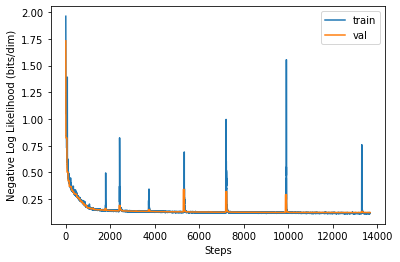

In [0]:
""" Training vs. Validation Loss (bits/dim) """

plt.xlabel('Steps')
plt.ylabel('Negative Log Likelihood (bits/dim)')
plt.plot(training_loss,label='train')
plt.plot(validation_loss,label='val')
plt.legend()
plt.show()

In [0]:
with torch.no_grad():
  total_test_loss = 0
  pixel_cnn.eval()
  for batch in test_data:
    batch = batch.cuda()
    test_logits = pixel_cnn.forward(batch)
    test_logits = test_logits.flatten(0,3)

    test_loss = F.cross_entropy(test_logits,batch.flatten().long())* np.log2(np.e)
    total_test_loss += test_loss.item()

print("Test Loss:",total_test_loss/len(test_data),"bits/dim")

Test Loss: 0.12214250249575966 bits/dim


In [0]:
""" Sampling each pixel sequentially and each color channel in parallel """

sm = torch.nn.Softmax(dim=1)
num_samps = 100
images = torch.zeros(size=(num_samps,3,28,28)).cuda()
pixel_cnn.eval()

for i in range(28):
  for j in range(28):
    logits = pixel_cnn.forward(images)

    r_log = logits[:,0,i,j]
    g_log = logits[:,1,i,j]
    b_log = logits[:,2,i,j]

    r_prob = sm(r_log)
    g_prob = sm(g_log)
    b_prob = sm(b_log)

    r_prob_dist = torch.distributions.Categorical(r_prob)
    g_prob_dist = torch.distributions.Categorical(g_prob)
    b_prob_dist = torch.distributions.Categorical(b_prob)

    r=r_prob_dist.sample([1])
    g=g_prob_dist.sample([1])
    b=b_prob_dist.sample([1])

    images[:,0,i,j] = r.flatten()
    images[:,1,i,j] = g.flatten()
    images[:,2,i,j] = b.flatten()


images = images.permute(0,2,3,1).cpu()

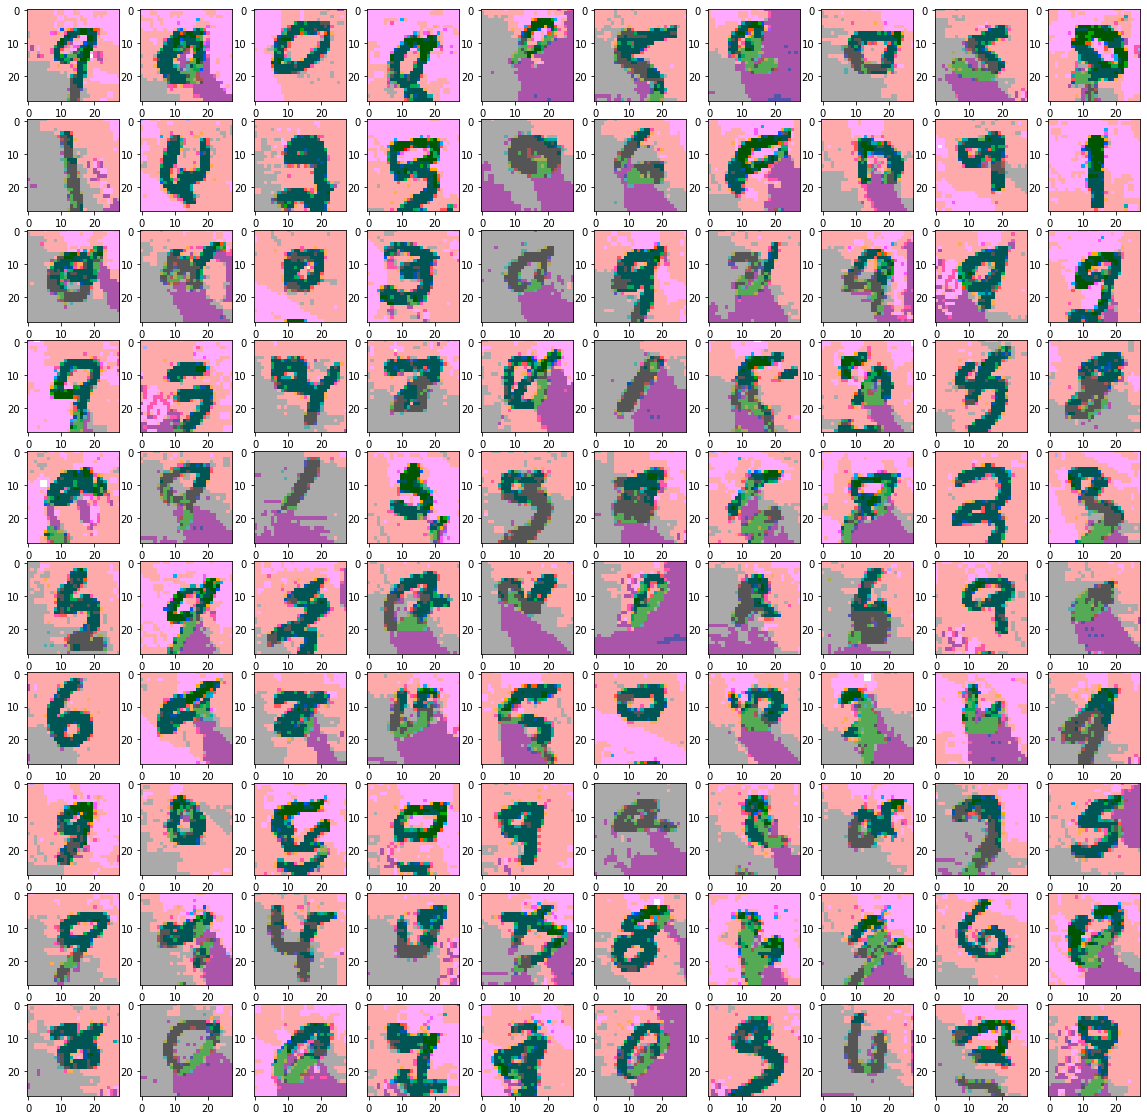

In [0]:
""" 100 generated images from the Pixel-CNN """

f, axarr = plt.subplots(10,10,figsize=(20,20))
k = 0
for i in range(10):
  for j in range(10):
    axarr[i,j].imshow(images[k]/3)
    k+=1

In [0]:
""" Same function used for the MADE on 2D data"""

def get_mk(num_dim, output_size, last=False):
    if last == False:
        mk = np.random.randint(1, num_dim, output_size)

    else:
        for i in range(1, num_dim + 1):
            if i == 1:
                mk = np.random.randint(i, i + 1, output_size//num_dim)
            else:
                mk = np.concatenate((mk, np.random.randint(i, i + 1, output_size//num_dim)))
    return mk

""" 
MADE is taking Pixel-CNN output as auxillary input at each layer so we need to
ensure that we do not mask this input by adding 1's to each mask corresponding to
the size of the auxillary input. In this case input size is 12 as we have a 
4-way softmax for each color channel.
"""

def get_mask_md(prev_mk, mk,output_size,num_aux,last=False):
    input_size = len(prev_mk)

    mask = torch.ones(output_size, input_size).cuda()
    aux_mask = torch.ones(output_size,num_aux).cuda()

    for i in range(len(mask)):
        for j in range(len(mask[i])):
            if last == False:
                if mk[i] >= prev_mk[j]:
                    mask[i][j] = 1.
                else:
                    mask[i][j] = 0.
            else:
                if mk[i] > prev_mk[j]:
                    mask[i][j] = 1.
                else:
                    mask[i][j] = 0.

    mask = torch.cat((aux_mask,mask),1)
    
    return mask

In [0]:
""" Same masked layer from MADE on 2D data"""

class MaskedLayer(nn.Linear):

    def __init__(self, in_features, out_features, mask, bias=True):
        super().__init__(in_features, out_features, bias)

        self.mask = mask

    def forward(self, input):
        return F.linear(input, torch.mul(self.mask, self.weight), self.bias)


""" 
3 layer MADE taking in the Pixel-CNN output as auxillary input is being
used to model the dependencies between color channels
"""

class PixelCNN_MADE(torch.nn.Module):

    def __init__(self, block, PixelCNN, mask1_pc, mask2_pc, mask1_md,
                 mask2_md, mask3_md):
        super(PixelCNN_MADE, self).__init__()

        self.pixel_cnn = PixelCNN(block, mask1_pc, mask2_pc)
        self.relu = torch.nn.ReLU()
        self.l1 = MaskedLayer(24, 200, mask1_md)
        self.l2 = MaskedLayer(212, 200, mask2_md)
        self.l3 = MaskedLayer(212, 12, mask3_md)

    def forward(self, input):
      out = self.pixel_cnn.forward(input)
      one_hot = F.one_hot(input.flatten().long(), 4).cuda()
      one_hot = one_hot.view(len(input),3,28,28,4).float()

      one_hot = one_hot.permute(0,2,3,1,4)
      one_hot = one_hot.reshape(len(input),28,28,12)
      one_hot = one_hot.flatten(0,2)

      aux = out.permute(0,2,3,1,4)
      aux = aux.reshape(len(input),28,28,12)
      aux = aux.flatten(0,2)
    
      out = self.l1(torch.cat((aux,one_hot),1))
      out = self.relu(out)
      out = self.l2(torch.cat((aux,out),1))
      out = self.relu(out)
      out = self.l3(torch.cat((aux,out),1))
      out = out.view(len(one_hot),3,4)

      return out


In [0]:
""" Precomputing mask for the MADE """

num_chan = 3

mk_0 = get_mk(num_chan, 12, True)
mk_1 = get_mk(num_chan, 200)
mk_2 = get_mk(num_chan, 200)
mk_3 = get_mk(num_chan, 12, True)

mask1_md = get_mask_md(mk_0, mk_1, 200,12)
mask2_md = get_mask_md(mk_1, mk_2, 200,12)
mask3_md = get_mask_md(mk_2, mk_3, 12,12, True)


In [0]:
pixel_cnn_made = PixelCNN_MADE(ResBlock, PixelCNN, mask1_pc, mask2_pc, mask1_md,
                 mask2_md, mask3_md)

use_cuda = True
if use_cuda and torch.cuda.is_available():
  pixel_cnn_made.cuda()

batch_size = 128
epochs = 40

optimizer = torch.optim.Adam(pixel_cnn_made.parameters(), lr=0.001)

training_loss = []
validation_loss = []

""" Training Loop"""

m=0
for i in range(epochs):
    j=0
    for batch in training_data:
      optimizer.zero_grad()
      batch = batch.cuda()
      logits = pixel_cnn_made.forward(batch)
      logits = logits.flatten(0,1)

      loss = F.cross_entropy(logits, batch.permute(0,2,3,1).flatten().long()) * np.log2(np.e)
      if j == len(training_data)-1 or (i == 0 and j == 0):
        print("Epoch:",i, "  Batch:",j,"  Loss:",loss.item(),"bits/dim")
      
      training_loss.append(loss.item())
      j += 1
      m += 1
      loss.backward()
      torch.nn.utils.clip_grad_norm_(pixel_cnn_made.parameters(), 1)
      optimizer.step()

      if m % 50 == 0 or j == len(training_data)-1 or (i==0 and j==1):
        with torch.no_grad():
          total_val_loss = 0
          pixel_cnn_made.eval()
          for batch in validation_data:
            batch = batch.cuda()
            val_logits = pixel_cnn_made.forward(batch)
            val_logits = val_logits.flatten(0,1)

            val_loss = F.cross_entropy(val_logits,batch.permute(0,2,3,1).flatten().long())* np.log2(np.e)
            total_val_loss += val_loss.item()
          for num in range(m):
            validation_loss.append(total_val_loss/len(validation_data))
          pixel_cnn_made.train()
          m = 0

Epoch: 0   Batch: 0   Loss: 1.9919966459274292 bits/dim
Epoch: 0   Batch: 390   Loss: 0.23125949501991272 bits/dim
Epoch: 1   Batch: 390   Loss: 0.10775496810674667 bits/dim
Epoch: 2   Batch: 390   Loss: 0.06989862769842148 bits/dim
Epoch: 3   Batch: 390   Loss: 0.0617181733250618 bits/dim
Epoch: 4   Batch: 390   Loss: 0.05826567858457565 bits/dim
Epoch: 5   Batch: 390   Loss: 0.05792415514588356 bits/dim
Epoch: 6   Batch: 390   Loss: 0.05664892867207527 bits/dim
Epoch: 7   Batch: 390   Loss: 0.05533311143517494 bits/dim
Epoch: 8   Batch: 390   Loss: 0.06455297023057938 bits/dim
Epoch: 9   Batch: 390   Loss: 0.05159038305282593 bits/dim
Epoch: 10   Batch: 390   Loss: 0.053859855979681015 bits/dim
Epoch: 11   Batch: 390   Loss: 0.05068046599626541 bits/dim
Epoch: 12   Batch: 390   Loss: 0.0508662611246109 bits/dim
Epoch: 13   Batch: 390   Loss: 0.052855562418699265 bits/dim
Epoch: 14   Batch: 390   Loss: 0.04864681884646416 bits/dim
Epoch: 15   Batch: 390   Loss: 0.04961048439145088 bit

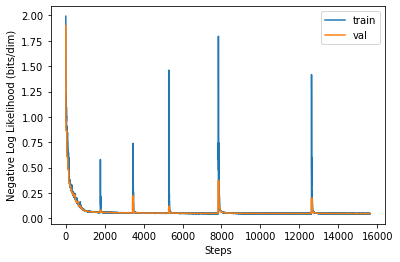

In [0]:
""" Training vs. Validation Loss (bits/dim) """

plt.xlabel('Steps')
plt.ylabel('Negative Log Likelihood (bits/dim)')
plt.plot(training_loss,label='train')
plt.plot(validation_loss,label='val')
plt.legend()
plt.show()

In [0]:
with torch.no_grad():
  total_test_loss = 0
  pixel_cnn_made.eval()
  for batch in test_data:
    batch = batch.cuda()
    test_logits = pixel_cnn_made.forward(batch)
    test_logits = test_logits.flatten(0,1)

    test_loss = F.cross_entropy(test_logits,batch.permute(0,2,3,1).flatten().long())* np.log2(np.e)
    total_test_loss += test_loss.item()

print("Test Loss:",total_test_loss/len(test_data),"bits/dim")

Test Loss: 0.047497838311180283 bits/dim


In [0]:
"""Adding inner loop to sampling procedure to sample color channels sequentially """

sm = torch.nn.Softmax(dim=1)
num_samps = 100
images = torch.zeros(size=(num_samps,3,28,28)).cuda()
pixel_cnn_made.eval()

for i in range(28):
  for j in range(28):
    for c in range(3):
      logits = pixel_cnn_made.forward(images)
      logits = logits.view(len(images),28,28,3,4)
      logits = logits.permute(0,3,1,2,4)

      color_log = logits[:,c,i,j]

      color_prob = sm(color_log)

      color_prob_dist = torch.distributions.Categorical(color_prob)

      color=color_prob_dist.sample([1])

      images[:,c,i,j] = color.flatten()

images = images.permute(0,2,3,1).cpu()

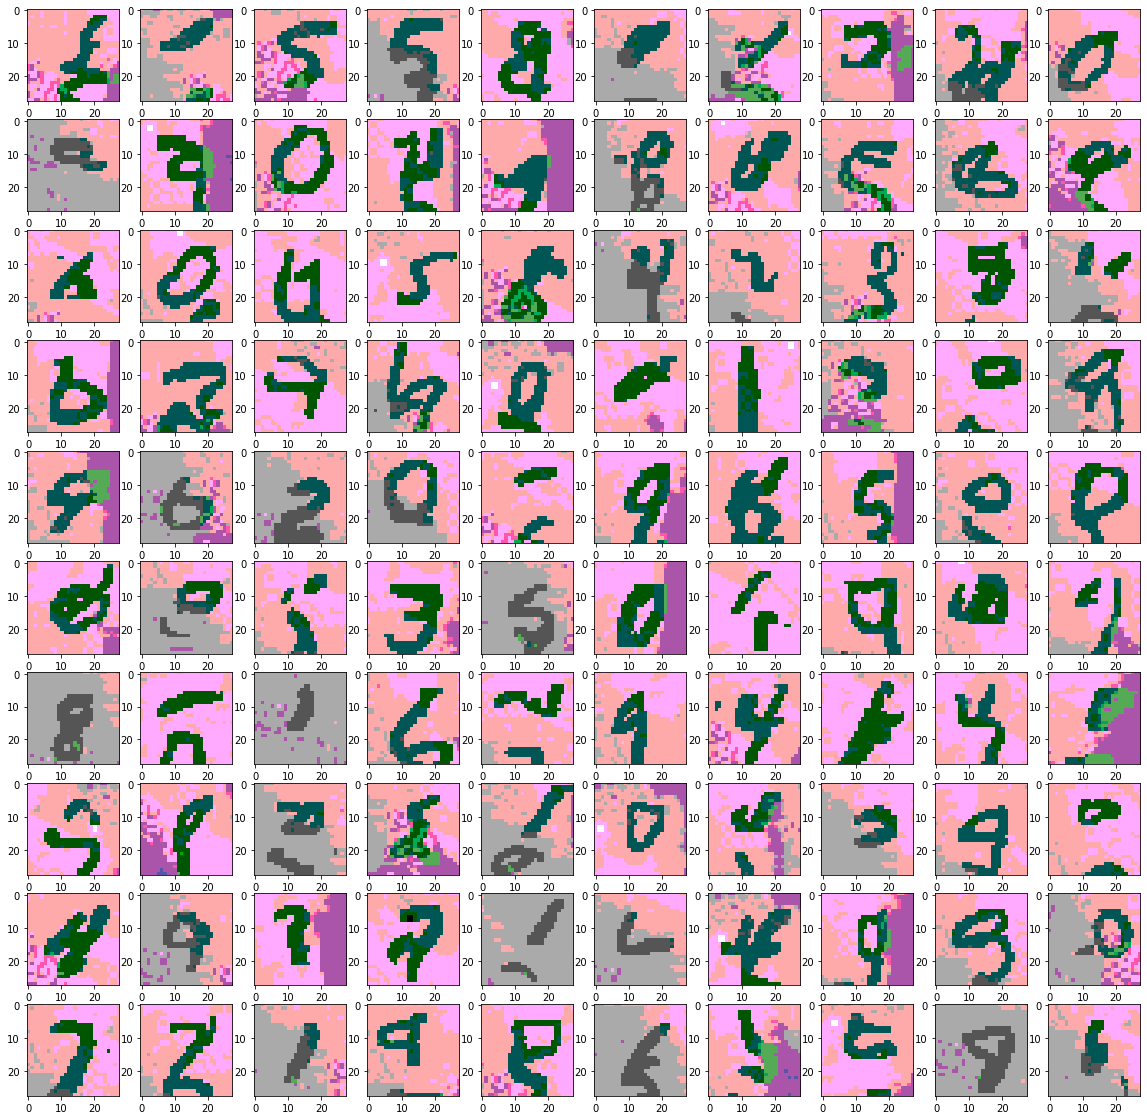

In [0]:
""" 100 generated images from the Pixel-CNN-MADE """

f, axarr = plt.subplots(10,10,figsize=(20,20))
k = 0
for i in range(10):
  for j in range(10):
    axarr[i,j].imshow(images[k]/3)
    k+=1

In [0]:
""" 
Getting gradient of log prob of center pixel in an image with respect to the 
input pixels in order to allow for visualizing the initial receptive field of the model
"""

pixel_cnn_made_recep = PixelCNN_MADE(ResBlock, PixelCNN, mask1_pc, mask2_pc, mask1_md,
                 mask2_md, mask3_md)

use_cuda = True
if use_cuda and torch.cuda.is_available():
  pixel_cnn_made_recep.cuda()

image = training_set[0].view(1,3,28,28).cuda()
image.requires_grad=True
logits = pixel_cnn_made_recep.forward(image)

logits = logits.view(28,28,3,4)
p_image = image.view(3,28,28)
p_image = p_image.permute(1,2,0)

p_image = p_image[13][13]
loss = F.cross_entropy(logits[13][13], p_image.long()) * np.log2(np.e)

loss.backward()

pix_grad = image.grad

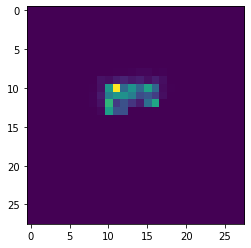

In [0]:
""" 
Visualiztion of the Pixel-CNN-MADE's inductive bias regarding its receptive field 
demonstrated by the center pixel
"""

pix_grad = pix_grad.flatten(0,1)
pix_grad = pix_grad.permute(1,2,0)
pix_grad = torch.abs(pix_grad)
pix_grad = pix_grad.max(2).values
plt.imshow(pix_grad.cpu())

plt.show()